In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import dspy
from dspy.datasets import DataLoader

/home/ray/anaconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# subsets: "['Accounting', 'Agriculture', 'Architecture_and_Engineering', 'Art', 'Art_Theory', 'Basic_Medical_Science', 'Biology', 'Chemistry', 'Clinical_Medicine', 'Computer_Science', 'Design', 'Diagnostics_and_Laboratory_Medicine', 'Economics', 'Electronics', 'Energy_and_Power', 'Finance', 'Geography', 'History', 'Literature', 'Manage', 'Marketing', 'Materials', 'Math', 'Mechanical_Engineering', 'Music', 'Pharmacy', 'Physics', 'Psychology', 'Public_Health', 'Sociology']"
image_keys = [f"image_{i}" for i in range(1, 8)]
dataset = DataLoader().from_huggingface("MMMU/MMMU", "Math", split=["dev", "validation"], input_keys=("question", *image_keys))

In [10]:
dataset

{'dev': [Example({'id': 'dev_Math_1', 'question': 'Each of seven students has chosen three courses from ten options, and must sit an exam for each of his or her three choices. Two students sitting the same exam must do so at the same time, but no student can sit more than one exam in the same day. The table of choices is given in <image 1>. Find the smallest number of days required to schedule the exams. Return only the number of days.', 'options': '[]', 'explanation': '', 'image_1': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=744x261 at 0x6FFC9011C380>, 'image_2': None, 'image_3': None, 'image_4': None, 'image_5': None, 'image_6': None, 'image_7': None, 'img_type': "['Tables']", 'answer': '4', 'topic_difficulty': 'Easy', 'question_type': 'open', 'subfield': 'Graph Theory'}) (input_keys={'image_2', 'image_1', 'image_4', 'image_5', 'image_6', 'image_3', 'image_7', 'question'}),
  Example({'id': 'dev_Math_2', 'question': 'For the function f(x) = 8x^3 - 2x^2 - 7x + 3, perform two

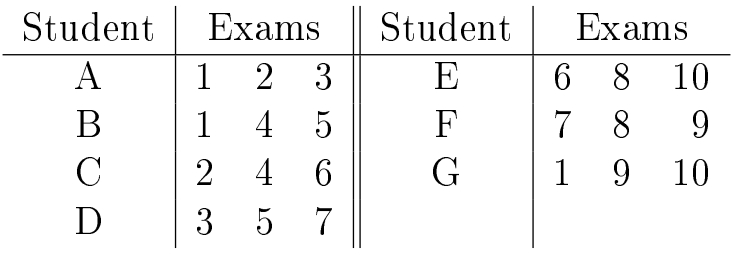

In [13]:
test_input = dataset["dev"][0]
test_input